In [1]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from num2words import num2words
from collections import Counter
from sklearn.manifold import TSNE

import seaborn as sn
import operator
import nltk
import os
import string
import numpy as np
import copy
import pandas as pd
import pickle
import math
import matplotlib.pyplot as plt

%load_ext autotime

In [2]:
def print_doc(id):
    file = open(paths[id], 'r', encoding='cp1250')
    text = file.read().strip()
    file.close()
    print(text)

time: 5.48 ms


In [3]:
def convert_numbers(k):
    for i in range(len(k)):
        try:
            k[i] = num2words(int(k[i]))
        except:
            pass
    return k

time: 4.84 ms


In [4]:
def doc_freq(word):
    c = 0
    try:
        c = DF[word]
    except:
        pass
    return c

time: 2.07 ms


In [5]:
def preprocess(pd):
    pd = pd.str.lower()
    pd = pd.str.replace('[{}]'.format('!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~\n\t'), '')
    pd = pd.apply(lambda x: [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(x)])
   
#     pd = pd.apply(lambda x: [w for w in w_tokenizer.tokenize(x)]) 
    
    pd = pd.apply(lambda x: convert_numbers(x))
    pd = pd.str.join(' ')
#     pd = pd.str.replace('[{}]'.format(string.punctuation), ' ')
    
#     pd = pd.apply(lambda x: [w for w in w_tokenizer.tokenize(x)])    
    pd = pd.apply(lambda x: [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(x)])    
    pd = pd.apply(lambda x: [item for item in x if item not in stop_words])
#     pd = pd.apply(lambda x: [stemmer.stem(y) for y in x])
    return pd

time: 7.54 ms


In [6]:
def calc_accuracy(predicted, true):
    tp_tn = len([1 for i in range(len(predicted)) if predicted[i]==true[i]])
    return tp_tn/len(predicted)

time: 2.36 ms


In [7]:
def compute_confusion(predicted, true):
    confusion = np.zeros((len(unique_labels), len(unique_labels))).astype(int)
    for i in range(len(predicted)):
        confusion[unique_labels.index(predicted[i])][unique_labels.index(true[i])] += 1
    sn.heatmap(pd.DataFrame(confusion), annot=True,cmap='Blues', fmt='g')
    return confusion

time: 3.69 ms


In [8]:
stop_words = stopwords.words('english')

time: 10.2 ms


In [9]:
lemmatizer = nltk.stem.WordNetLemmatizer()
stemmer = nltk.stem.PorterStemmer()
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()

time: 2.23 ms


In [10]:
title = "20_newsgroups"
unique_labels = ['comp.graphics', 'rec.sport.hockey', 'sci.med', 'sci.space', 'talk.politics.misc']

time: 2.6 ms


In [11]:
def generate_corpus_pd():
    paths = []
    labels = []
    for l in unique_labels:
        for (dirpath, dirnames, filenames) in os.walk(str(os.getcwd())+'/'+title+'/'+str(l)):
            for i in filenames:
                paths.append(str(dirpath)+str("/")+i)
                labels.append(l)

    doc = 0
    docs = []

    for path in paths:
        file = open(path, 'r', encoding='cp1250')
        text = file.read().strip()
        file.close()

        docs.append(text)

        if doc%1000 == 0:
            print(doc)

        doc += 1
    docs_pd = pd.DataFrame([docs, labels]).T
    docs_pd[0] = preprocess(docs_pd[0])
    docs_pd.to_pickle("docs_pd")

time: 8.19 ms


In [12]:
# generate_corpus_pd()

time: 2 ms


In [13]:
def load_corpus_pd(split):
    docs_pd = pd.read_pickle("docs_pd")
    a = []
    for i in unique_labels:
        a.append(docs_pd[docs_pd[1]==i].sample(frac=split,random_state=41))
    train = pd.concat([i for i in a])
    test = docs_pd.sample(frac=1,random_state=41).drop(train.index)
    train = train.reset_index(drop=True)
    test = test.reset_index(drop=True)
    return train, test

time: 14.3 ms


In [14]:
def gen_class_data(train):
    m = {}
    for i in range(train.shape[0]):
        try:
            m[train[1][i]] = m[train[1][i]] + train[0][i]
        except:
            m[train[1][i]] = train[0][i]
    return m

time: 3.24 ms


In [15]:
def run_1(train, test):
    m = gen_class_data(train)

    unique_words = set()
    ck = 0
    for i in m:
        unique_words = unique_words | set(m[i])
        ck += len(m[i])
    unique_words_count = len(unique_words)
    print("Corpus Size", ck, "Unique Words", unique_words_count)

    class_frequency = {}
    class_count = {}
    counter = 0
    for i in unique_labels:
        current_count = len(Counter(m[i]))
        class_count[i] = current_count
        counter += current_count
        ll = Counter(m[i])
        for j in ll:
            class_frequency[i, j] = ll[j]

    def get_word_freq(word, label):
        try:
            return class_frequency[label, word], class_count[label]
        except:
            return 0, class_count[label]

    train_class_split = Counter(train[1])
    true = []
    predicted = []
    for i in range(test.shape[0]):
        true.append(test[1][i])
        classes_words_probability = []
        for l in unique_labels:
            words_probability = 0
            for word in test[0][i]:
                fr, cn = get_word_freq(word, l)
                pp = (fr + 1)/(cn + unique_words_count)
                words_probability += np.log(pp)
            words_probability += np.log(train_class_split[l] / train.shape[0])
            classes_words_probability.append(words_probability)
        predicted.append(unique_labels[np.argmax(classes_words_probability)])

    print(compute_confusion(predicted, true))
    print(calc_accuracy(predicted, true))

time: 26.1 ms


# Question 2

In [16]:
def run_2(train, test, percentage):
    m = gen_class_data(train)

    corpus = []
    for i in m:
        corpus = corpus + m[i]
    
    DF = {}

    n = 0
    for tokens in train[0]:
        for w in tokens:
            try:
                DF[w].add(n)
            except:
                DF[w] = {n}
        n += 1
    for i in DF:
        DF[i] = len(DF[i])

    def doc_freq(word):
        c = 0
        try:
            c = DF[word]
        except:
            pass
        return c

    tf_idf = {}
    N = train.shape[0]

    counter = Counter(corpus)
    words_count = len(corpus)

    for token in set(corpus):
        tf = counter[token]/words_count
        df = doc_freq(token)
        idf = np.log((N+1)/(df+1))

        tf_idf[token] = tf*idf


    sorted_x = sorted(tf_idf.items(), key=operator.itemgetter(1), reverse=True)

    refined_data = sorted_x[:int(len(sorted_x)*percentage/100)]

    refined_data = [i[0] for i in refined_data]

    unique_words_count = len(sorted_x[:int(len(sorted_x)*percentage/100)])

    print("Corpus Size", words_count, "Unique Words", unique_words_count)
    class_frequency = {}
    class_count = {}
    for i in unique_labels:
        ll = Counter(m[i])
        for j in refined_data:
            class_frequency[i, j] = ll[j]
            try:
                class_count[i] = class_count[i] + ll[j]
            except:
                class_count[i] = ll[j]

    def get_word_freq(word, label):
        try:
            return class_frequency[label, word], class_count[label]
        except:
            return 0, class_count[label]

    train_class_split = Counter(train[1])
    true = []
    predicted = []
    for i in range(test.shape[0]):
        true.append(test[1][i])
        classes_words_probability = []
        for l in unique_labels:
            words_probability = 0
            for word in test[0][i]:
                fr, cn = get_word_freq(word, l)
                pp = (fr + 1) / (cn + unique_words_count)
                words_probability += np.log(pp)
            words_probability += np.log(train_class_split[l] / train.shape[0])
            classes_words_probability.append(words_probability)
        predicted.append(unique_labels[np.argmax(classes_words_probability)])

    print(compute_confusion(predicted, true))
    print(calc_accuracy(predicted, true))

time: 35.3 ms


In [17]:
print(unique_labels)

['comp.graphics', 'rec.sport.hockey', 'sci.med', 'sci.space', 'talk.politics.misc']
time: 1.64 ms


In [18]:
train, test = load_corpus_pd(0.5)

time: 401 ms


Corpus Size 490328 Unique Words 80647
[[465   1   7   4   0]
 [  3 493   4   1   4]
 [  0   0 459   2   2]
 [ 14   0  11 478   4]
 [ 18   6  19  15 490]]
0.954


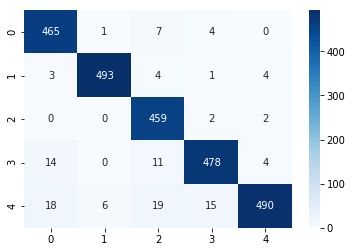

time: 14.4 s


In [19]:
run_1(train, test)

In [20]:
train, test = load_corpus_pd(0.7)

time: 380 ms


Corpus Size 698143 Unique Words 104924
[[286   1   5   4   0]
 [  1 294   2   0   1]
 [  1   0 275   0   0]
 [  5   0   5 289   1]
 [  7   5  13   7 298]]
0.9613333333333334


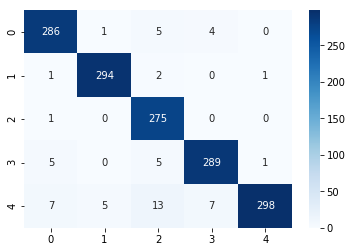

time: 17.6 s


In [21]:
run_1(train, test)

In [22]:
train, test = load_corpus_pd(0.8)

time: 340 ms


Corpus Size 824496 Unique Words 115354
[[196   1   3   2   0]
 [  0 196   2   0   2]
 [  0   0 189   1   0]
 [  1   0   1 192   1]
 [  3   3   5   5 197]]
0.97


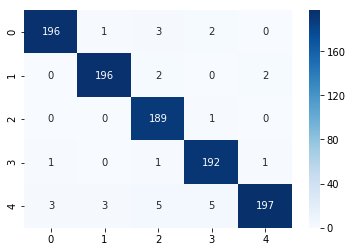

time: 14.9 s


In [23]:
run_1(train, test)

In [24]:
train, test = load_corpus_pd(0.9)

time: 346 ms


Corpus Size 922036 Unique Words 125066
[[97  0  3  1  0]
 [ 0 97  0  0  0]
 [ 0  0 95  0  0]
 [ 1  0  0 95  1]
 [ 2  3  2  4 99]]
0.966


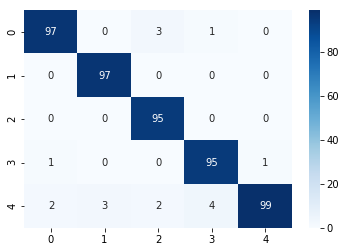

time: 15.2 s


In [25]:
run_1(train, test)

In [26]:
train, test = load_corpus_pd(0.7)

time: 327 ms


Corpus Size 698143 Unique Words 41969
[[299   3   8   6   4]
 [  0 297   2   0   5]
 [  0   0 284   3   0]
 [  1   0   5 289   7]
 [  0   0   1   2 284]]
0.9686666666666667


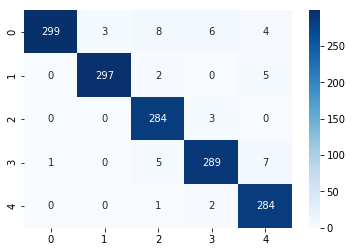

time: 16.8 s


In [27]:
run_2(train, test, 40)

Corpus Size 698143 Unique Words 52462
[[298   3   8   6   3]
 [  1 297   2   0   5]
 [  0   0 284   2   0]
 [  1   0   5 290   7]
 [  0   0   1   2 285]]
0.9693333333333334


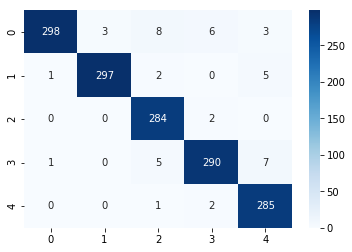

time: 14.9 s


In [28]:
run_2(train, test, 50)

Corpus Size 698143 Unique Words 62954
[[298   3   7   6   2]
 [  1 297   2   0   5]
 [  0   0 284   2   0]
 [  1   0   6 290   6]
 [  0   0   1   2 287]]
0.9706666666666667


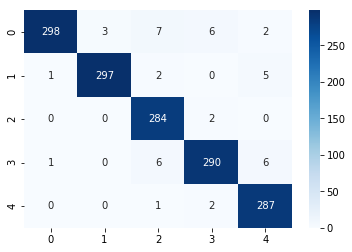

time: 15.6 s


In [29]:
run_2(train, test, 60)

Corpus Size 698143 Unique Words 73446
[[297   3   6   6   1]
 [  1 296   2   0   5]
 [  0   0 285   2   0]
 [  1   0   6 290   6]
 [  1   1   1   2 288]]
0.9706666666666667


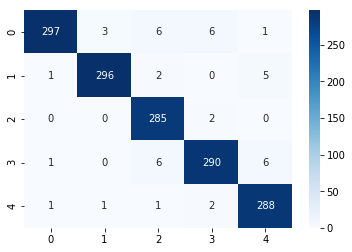

time: 13.9 s


In [30]:
run_2(train, test, 70)